# Applied Machine Learning Systems ELEC0134 (23/24) Assignment

## TASK A: 
Binary classification task (using PneumoniaMNIST dataset). The objective is to classify an image onto "Normal" (no pneumonia) or "Pneumonia" (presence of pneumonia)

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import random
from time import time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import svm

In [3]:
# 0: Normal; 1: Pneumonia
ac = np.load('pneumoniamnist.npz')
ac.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [110]:
class Augment():
    def __init__(self):
        self.inv_prob = 0.5
        self.blur_prob = 0.3
        self.sq_blur_prob = 0.3
        self.bright_prob = 0.5
        self.rotate_prob = 1.
        self.gray_prob = 0.0
 
    def invert(self, image):    # 色彩反转
        return 255 - image
 
    def blur(self, image):      # 均值滤波模糊
        return cv2.blur(image, (3, 3))
 
    def sq_blur(self, image):   # 区域插值模糊，模拟图像低分辨率
        image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
        return image
 
    def random_brightness(self, image): 
        c = random.uniform(0.2, 1.8)
        blank = np.zeros(image.shape, image.dtype)
        dst = cv2.addWeighted(image, c, blank, 1 - c, 0)
        return dst
 
    def rotate(self, image, scale=1.0): 
        angle = random.uniform(-5, 5)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, scale)
        rotated = cv2.warpAffine(image, M, (w, h))
        return rotated
 
    def gray_scale(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dst = cv2.merge((gray, gray, gray))
        return dst
 
    def apply(self, image):
        inv_prob = random.random()
        blur_prob = random.random()
        sq_blur_prob = random.random()
        bright_prob = random.random()
        rotate_prob = random.random()
 
        if inv_prob < self.inv_prob:
            image = self.invert(image)
 
        if bright_prob < self.bright_prob:
            image = self.random_brightness(image)
 
        if rotate_prob < self.rotate_prob:
            image = self.rotate(image)
 
        if blur_prob < self.blur_prob:
            image = self.blur(image)
 
        if sq_blur_prob < self.sq_blur_prob:
            image = self.sq_blur(image)
 
        return image

28
28


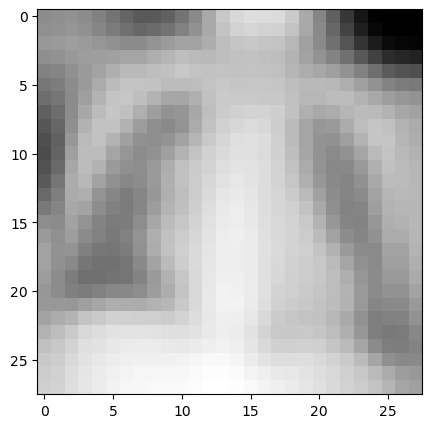

In [126]:
a = Augment()
t = a.blur(ac['train_images'][0])
print(len(ac['train_images'][0]))
print(len(t))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(t, cmap='gray')

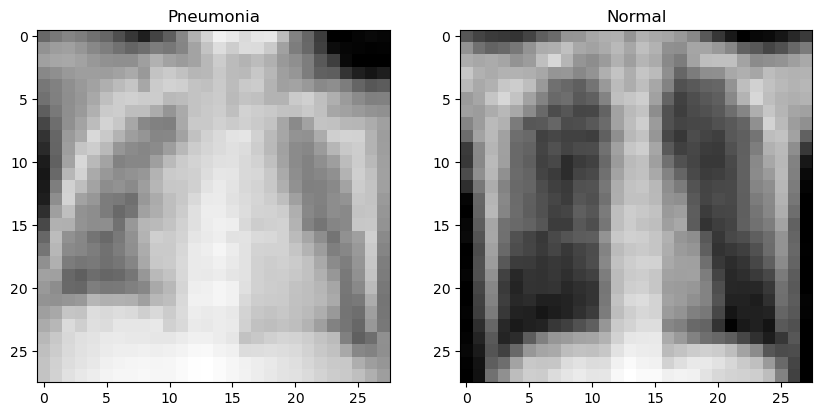

In [129]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ac['train_images'][0], cmap='gray')
ax.set_title('Pneumonia')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ac['train_images'][5], cmap='gray')
ax.set_title('Normal')
plt.show()

In [181]:
x_train, y_train = ac['train_images'], ac['train_labels']
x_val, y_val = ac['val_images'], ac['val_labels']
x_test, y_test= ac['test_images'], ac['test_labels']
x_train, y_train = np.vstack((x_train, x_val)), np.vstack((y_train, y_val))

x_train, x_test= x_train/255, x_test/255

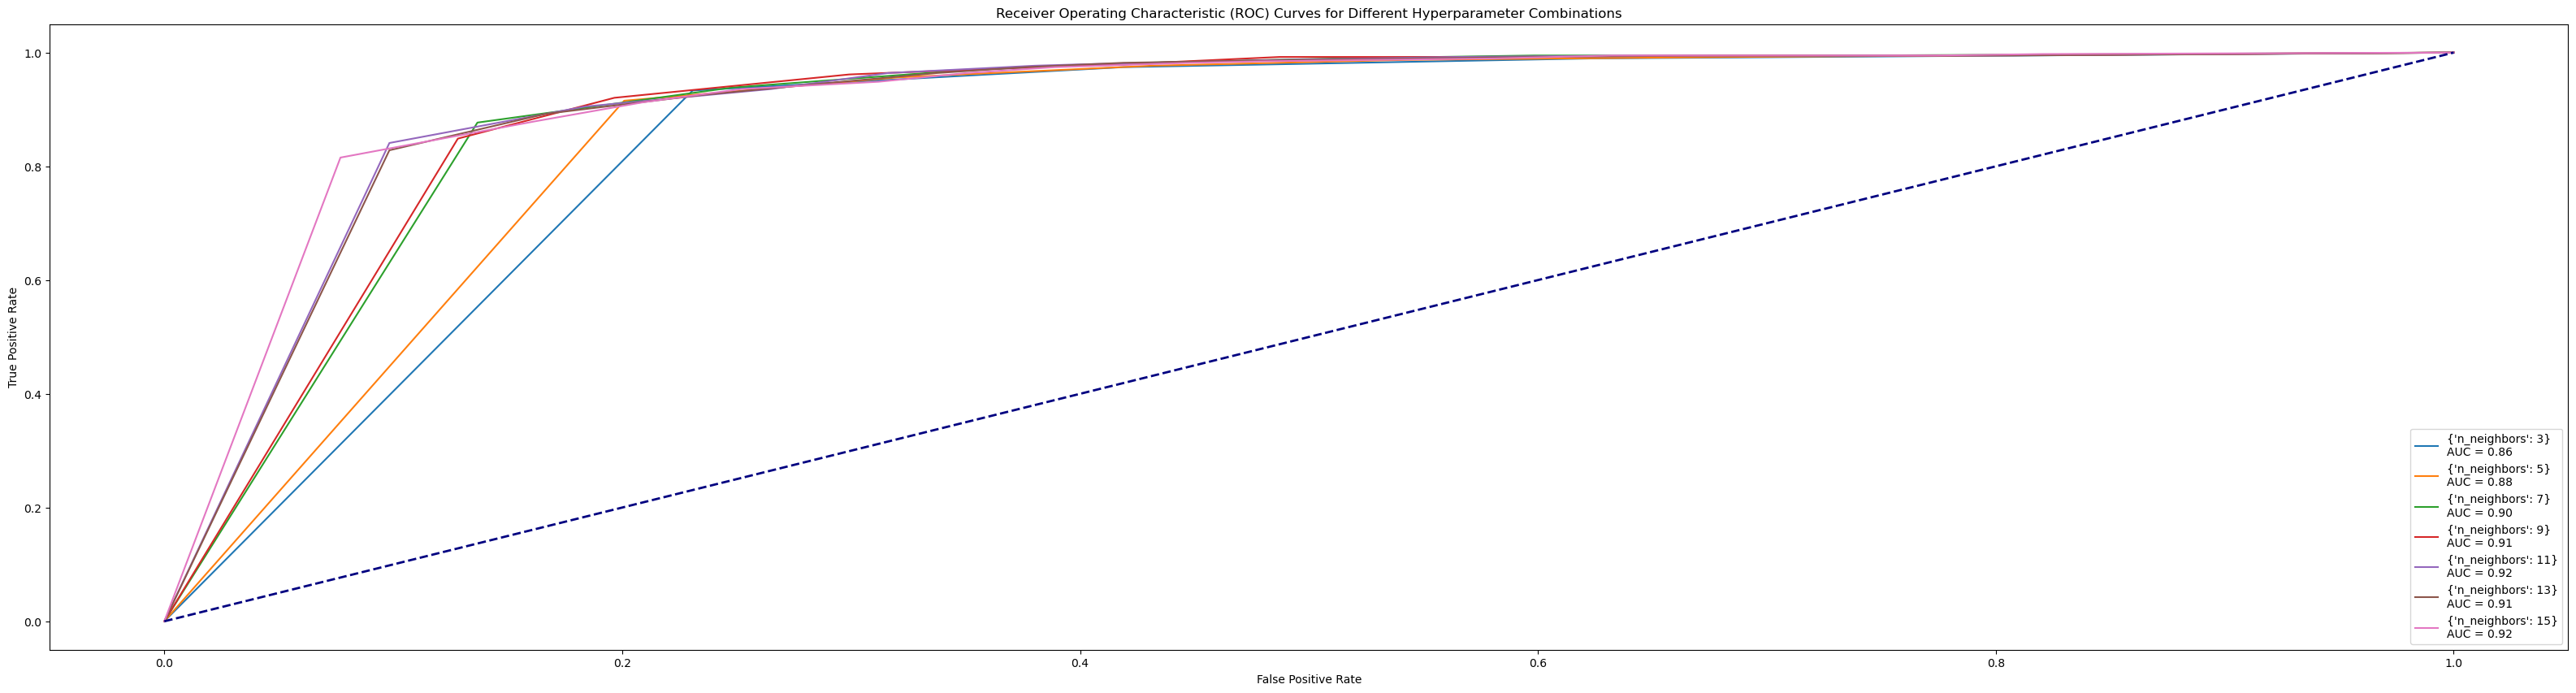

Best Parameters: {'n_neighbors': 9}
Best Accuracy: 0.94839393623957


In [237]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
model = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(x_train.reshape(-1, 28*28), y_train.ravel())
results = grid_search.cv_results_
fig = plt.figure(figsize=(40,10))
for i in range(len(results['params'])):
    param_set = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    model = KNeighborsClassifier(**param_set)
    model.fit(x_train.reshape(-1, 28*28), y_train.ravel())
    y_pred_proba = model.predict_proba(x_test.reshape(-1, 28*28))[:, 1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{param_set}\nAUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Hyperparameter Combinations')
plt.legend(loc='lower right')
plt.show()
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_}')

In [238]:
to = time()
clf = KNeighborsClassifier(**grid_search.best_params_).fit(x_train.reshape(-1, 28*28), y_train.ravel())
print('Training time: {:.5f}s'.format(time() - to))
predictions_labels = clf.predict(x_test.reshape(-1, 28*28))
print('Evaluation:')
print((classification_report(y_test, predictions_labels)))

Training time: 0.00189s
Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



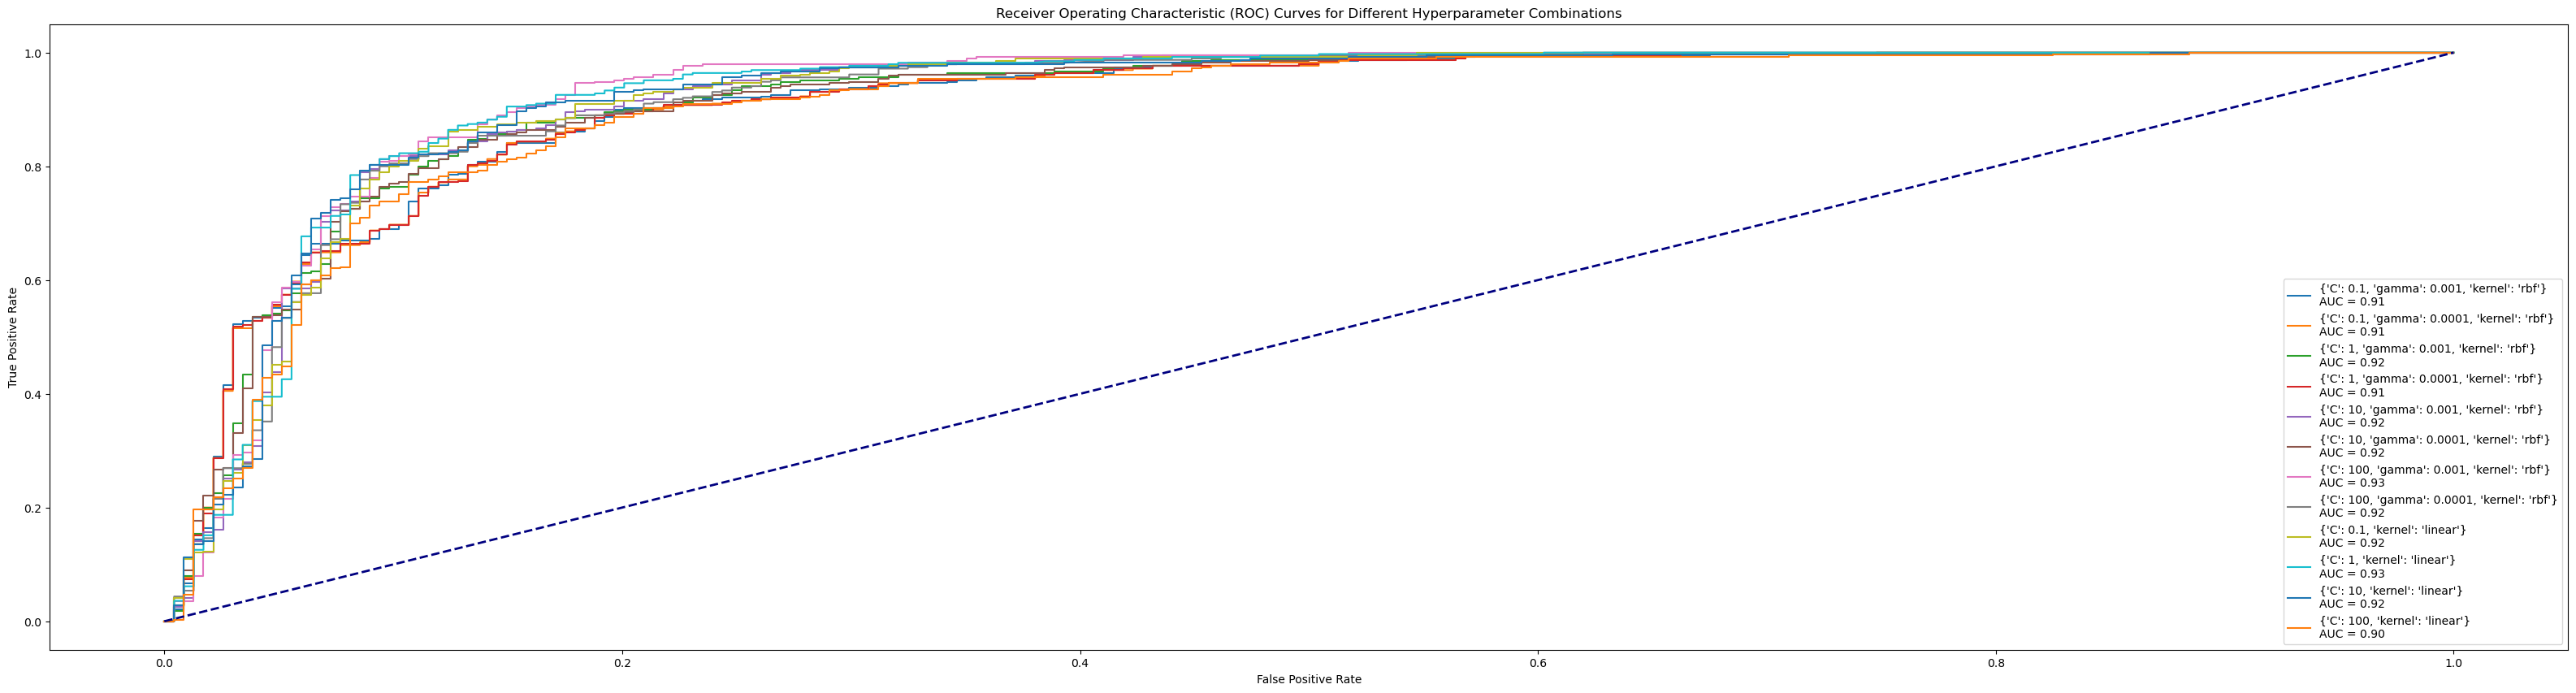

Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Accuracy: 0.961392013236398


In [228]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.1, 1, 10, 100]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]
model = svm.SVC()
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(x_train.reshape(-1, 28*28), y_train.ravel())
results = grid_search.cv_results_
fig = plt.figure(figsize=(40,10))
for i in range(len(results['params'])):
    param_set = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    model = svm.SVC(**param_set, probability=True)
    model.fit(x_train.reshape(-1, 28*28), y_train.ravel())
    y_pred_proba = model.predict_proba(x_test.reshape(-1, 28*28))[:, 1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{param_set}\nAUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Hyperparameter Combinations')
plt.legend(loc='lower right')
plt.show()
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_}')

In [235]:
to =time()
clf = svm.SVC(**grid_search.best_params_).fit(x_train.reshape(-1, 28*28), y_train.ravel())
print('Training time: {:.5f}s'.format(time() - to))
predictions_labels = clf.predict(x_test.reshape(-1, 28*28))
print('\r\nEvaluation:')
print((classification_report(y_test, predictions_labels)))

Training time: 1.44709s

Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



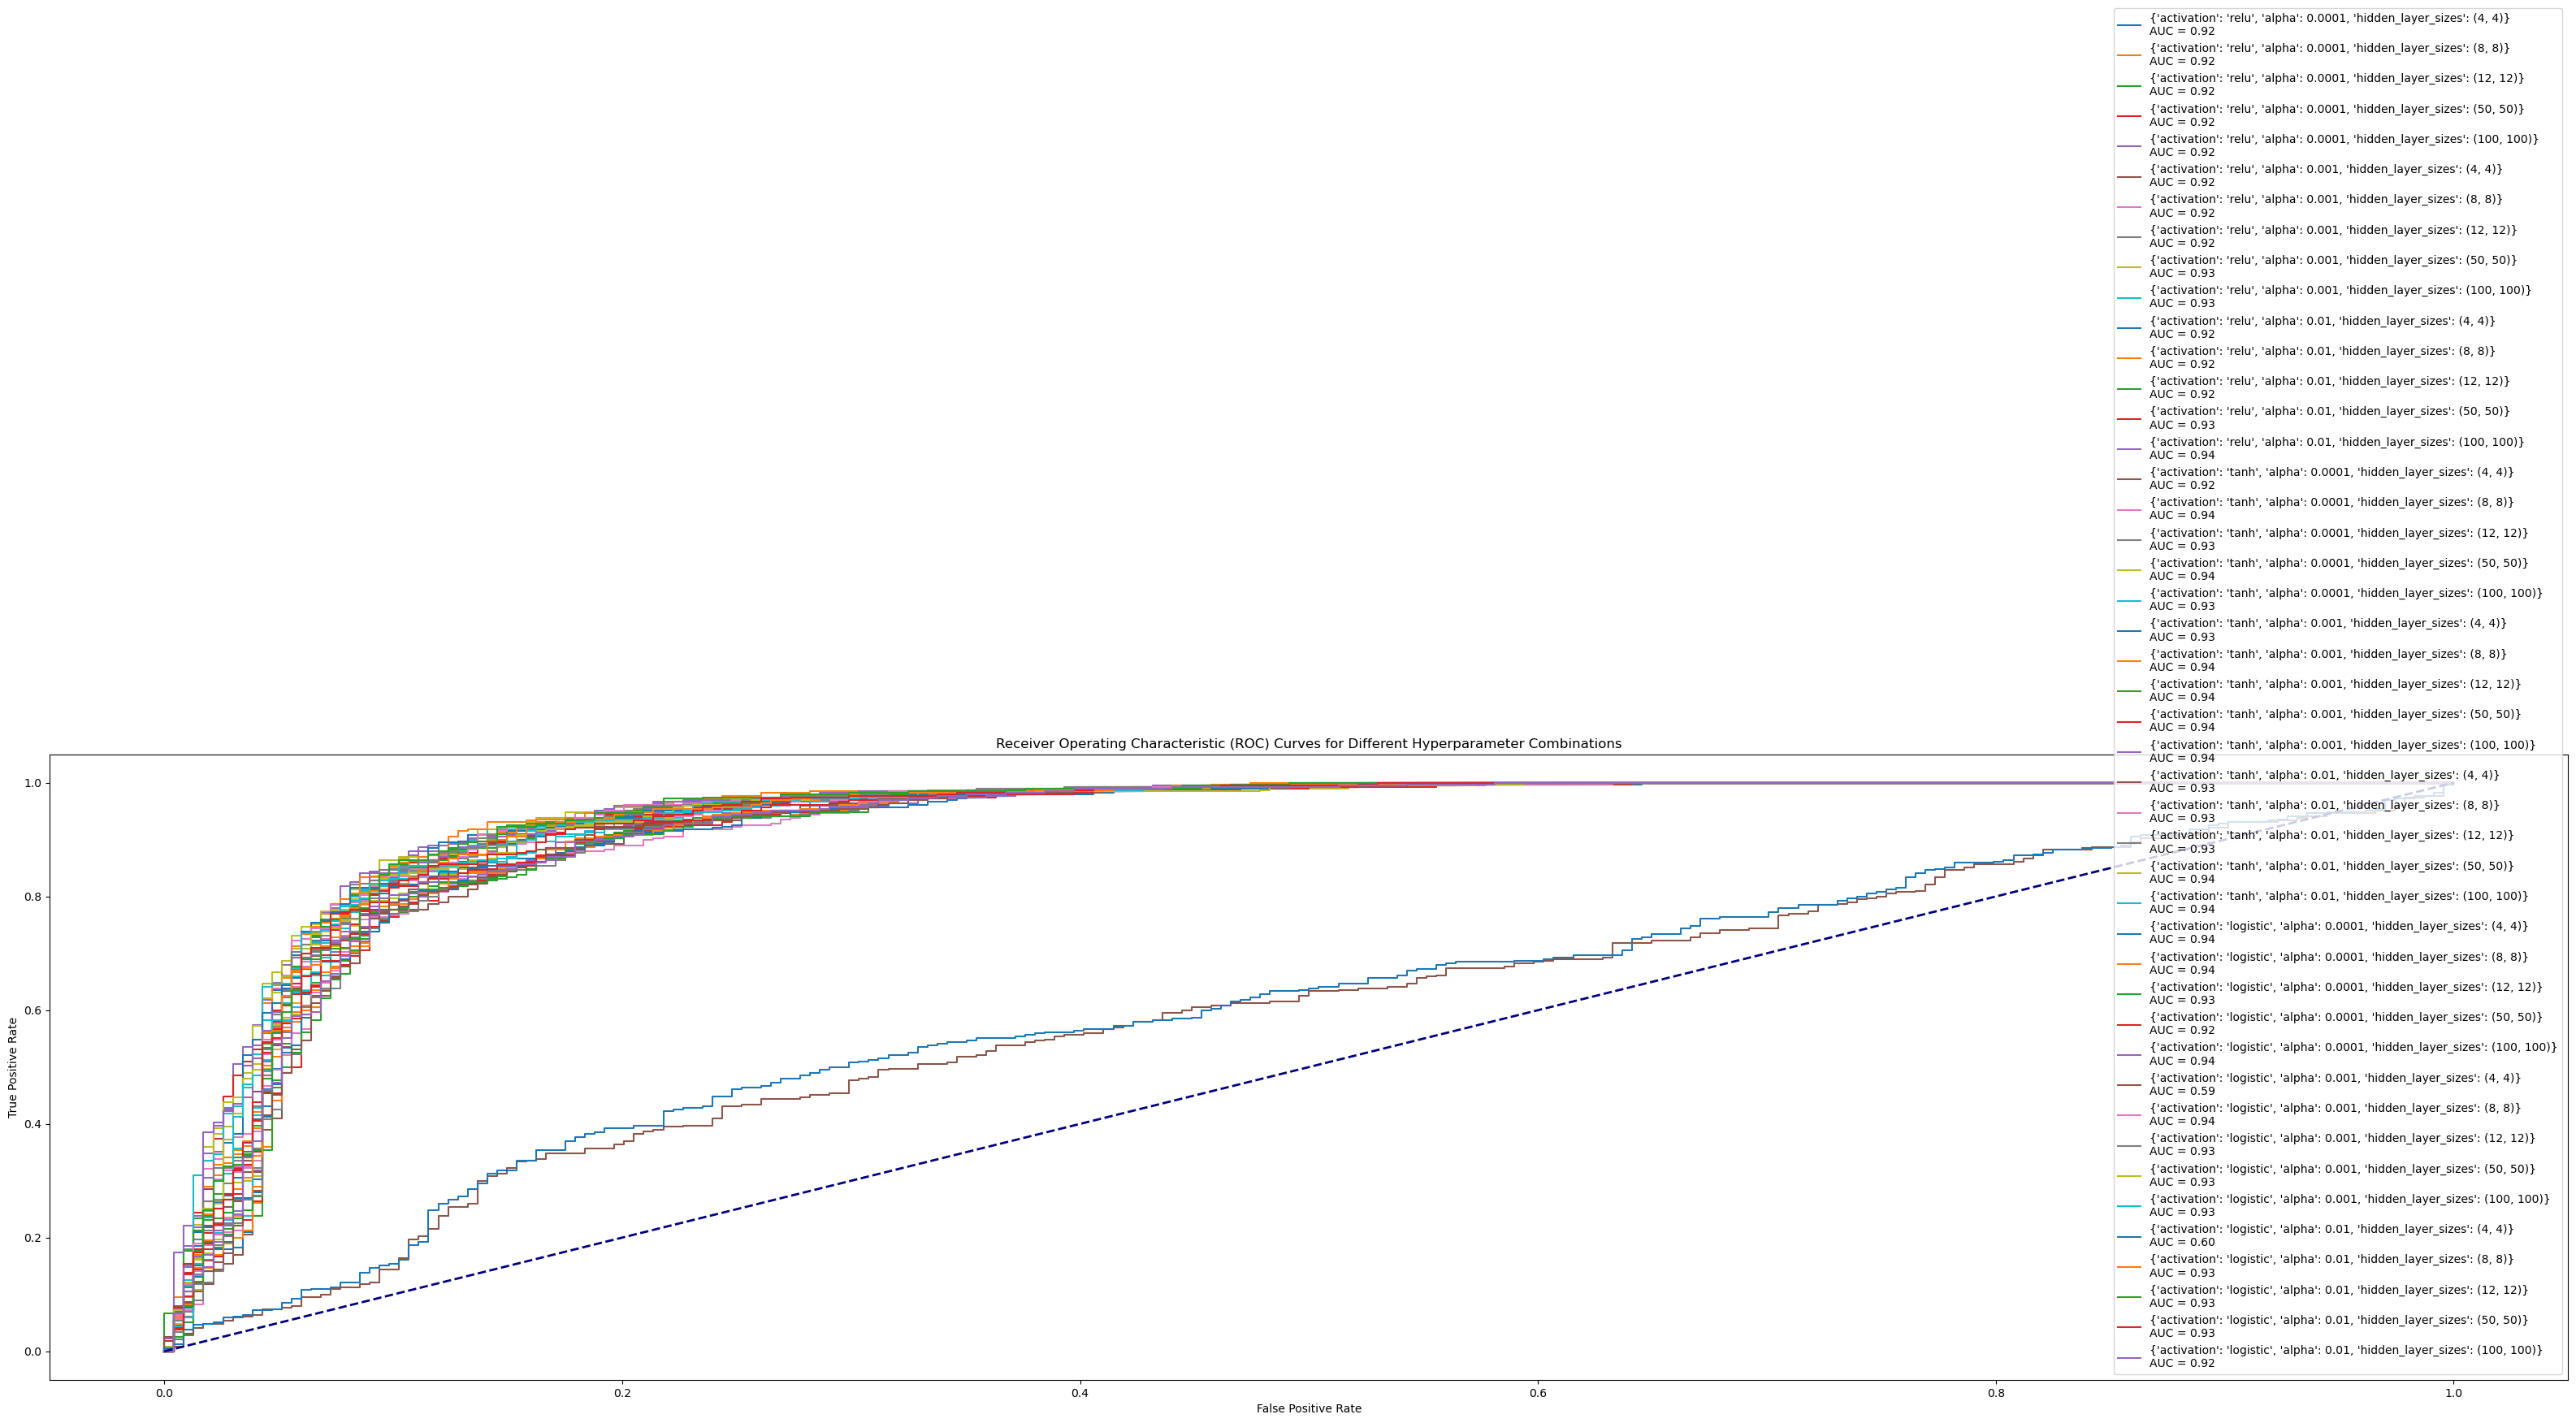

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}
Best Accuracy: 0.9661697538811609


In [241]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(4, 4,), (8, 8,), (12, 12,), (50, 50,), (100, 100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
}
model = MLPClassifier(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(x_train.reshape(-1, 28*28), y_train.ravel())
results = grid_search.cv_results_
fig = plt.figure(figsize=(40,10))
for i in range(len(results['params'])):
    param_set = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    model = MLPClassifier(**param_set, max_iter=1000)
    model.fit(x_train.reshape(-1, 28*28), y_train.ravel())
    y_pred_proba = model.predict_proba(x_test.reshape(-1, 28*28))[:, 1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{param_set}\nAUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Hyperparameter Combinations')
plt.legend(loc='lower right')
plt.show()
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_}')

In [243]:
to =time()
clf = MLPClassifier(**grid_search.best_params_, max_iter=1000).fit(x_train.reshape(-1, 28*28), y_train.ravel())
print('Training time: {:.5f}s'.format(time() - to))
predictions_labels = clf.predict(x_test.reshape(-1, 28*28))
print('\r\nEvaluation:')
print((classification_report(y_test, predictions_labels)))

Training time: 18.12568s

Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78       234
           1       0.82      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

